# Quantum circuit Born machine
## Experiment 1: Non-differentiable learning

In this notebook the quantum circuit born machine with non-differentiable learning is implemented and tested by learning and subsequently reproducing the a simple probability distribution.
For a complete reference of the implementation and explanation of the related theory see the main text of the project. For a complex application of this implementation see the notebook
ending in suffix Real instead of Basic.

Note that this code does not perform checks for validity of the input, for this reason the code should be reused with caution.

In [1]:
# Imports

from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library import EfficientSU2
from qiskit.primitives import Sampler, BackendSampler
from qiskit_aer import Aer, AerSimulator
from qiskit_aer.primitives import Sampler as AerSampler
from qiskit_aer.noise import NoiseModel
from qiskit.utils import algorithm_globals
from qiskit_algorithms.optimizers import ADAM, COBYLA
from qiskit_algorithms.utils import algorithm_globals
from qiskit_ibm_runtime import Sampler as IBMSampler
from qiskit_ibm_runtime import Session, Options, QiskitRuntimeService
from qiskit.transpiler import PassManager, Layout
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime.transpiler.passes.scheduling import (
    ALAPScheduleAnalysis,
    PadDynamicalDecoupling,
)
from qiskit.circuit.library import XGate

import numpy as np
import time
from scipy.stats import norm
# Import pandas
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from tqdm import tqdm
plt.rcParams['text.usetex'] = False
plt.rcParams["font.family"] = "serif"

In [2]:
use_ibm_sim = False
use_ibm_q = True

In [3]:
if use_ibm_sim or use_ibm_q:
    service = QiskitRuntimeService(name='hudecvl1.fjfi')

In [50]:
if use_ibm_sim:
    backend = 'simulator_statevector'
elif use_ibm_q:
    #backend = service.least_busy(simulator=False, operational=True)
    backend = service.get_backend('ibm_hanoi')
else:
    from qiskit.providers.fake_provider import FakeMumbaiV2
    backend = FakeMumbaiV2()
backend

<IBMBackend('ibm_hanoi')>

In [5]:
if use_ibm_q:
    options = Options(optimization_level=3)

In [6]:
# Global setup

num_qubits = 12
num_discrete_values = 2**num_qubits
shots = 1000

algorithm_globals.random_seed = 123456789

In [7]:
num_discrete_values

4096

In [8]:
# Helper functions

def rbf_kernel(x, y, sigma_list):
    exponent = np.abs(x[:, None] - y[None, :])**2
    K = 0.0
    for sigma in sigma_list:
        gamma = 1.0 / (2 * sigma)
        K = K + np.exp(-gamma * exponent)
    return K

class mmd:
    def __init__(self, sigma_list, basis, kernel):
        self.sigma_list = sigma_list
        self.basis = basis
        self.kernel=kernel
        self.K = self.kernel(basis, basis, self.sigma_list)

    def calc(self, px, py):
        pxy = px-py
        return self.kernel_expect(pxy, pxy)

    def kernel_expect(self, px, py):
        return px.dot(self.K).dot(py)

def dist(sampler, circuit, parameters):
    job = sampler.run(circuits=circuit, parameter_values=parameters)
    result = job.result()
    quasi_dist = result.quasi_dists[0]
    prob_dist = quasi_dist.nearest_probability_distribution()
    return prob_dist

def dist_pdf(dist):
    prob = []
    maximmum = int(num_qubits * '1', 2) + 1
    for key in range(0, maximmum):
        value = dist.get(key)
        if value:
            prob.append(value)
        else:
            prob.append(0)
    return np.array(prob)

def pd_process(data_df):
    res_proc = pd.DataFrame({'mean': data_df.mean(axis = 1),\
                           'std': data_df.std(axis = 1),\
                           'sem': data_df.sem(axis = 1)})
    return res_proc

In [9]:
# QCBM circuit
qr = QuantumRegister(num_qubits)
qc = QuantumCircuit(qr)
qc.h(qc.qubits)
ansatz = EfficientSU2(num_qubits, entanglement='circular', reps=2)
qc.compose(ansatz, inplace=True)
qc.measure_all()

In [10]:
l = Layout.from_intlist([1,4,7,10,12,13,14,11,8,5,3,2], qr)

In [38]:
pm = generate_preset_pass_manager(target=target, optimization_level=3, layout_method='sabre', initial_layout=l)

In [36]:
pm.scheduling = PassManager(
        [
            ALAPScheduleAnalysis(durations=target.durations()),
            PadDynamicalDecoupling(
                durations=target.durations(),
                dd_sequences=[XGate(), XGate()],
                pulse_alignment=target.pulse_alignment,
            ),
        ]
    )

In [37]:
pm.passes()

[{'passes': [<qiskit.transpiler.passes.utils.contains_instruction.ContainsInstruction at 0x7f37c5597450>],
  'flow_controllers': {}},
 {'passes': [<qiskit.transpiler.passes.utils.error.Error at 0x7f37c5597210>],
  'flow_controllers': {'condition'}},
 {'passes': [<qiskit.transpiler.passes.synthesis.unitary_synthesis.UnitarySynthesis at 0x7f37c5595590>],
  'flow_controllers': {}},
 {'passes': [<qiskit.transpiler.passes.synthesis.high_level_synthesis.HighLevelSynthesis at 0x7f37c5596b50>],
  'flow_controllers': {}},
 {'passes': [<qiskit.transpiler.passes.basis.basis_translator.BasisTranslator at 0x7f37c56404d0>],
  'flow_controllers': {}},
 {'passes': [<qiskit.transpiler.passes.optimization.optimize_swap_before_measure.OptimizeSwapBeforeMeasure at 0x7f37c56153d0>],
  'flow_controllers': {}},
 {'passes': [<qiskit.transpiler.passes.optimization.remove_diagonal_gates_before_measure.RemoveDiagonalGatesBeforeMeasure at 0x7f37f9786ad0>],
  'flow_controllers': {}},
 {'passes': [<qiskit.transpile

In [12]:
if not(use_ibm_sim):
    noise_model = NoiseModel.from_backend(backend)
    target = backend.target
    pm = generate_preset_pass_manager(target=target, optimization_level=3, layout_method='sabre', initial_layout=l)
    pm.scheduling = PassManager(
        [
            ALAPScheduleAnalysis(durations=target.durations()),
            PadDynamicalDecoupling(
                durations=target.durations(),
                dd_sequences=[XGate(), XGate()],
                pulse_alignment=target.pulse_alignment,
            ),
        ]
    )

In [39]:
if not(use_ibm_sim):
    qc_transpiled = pm.run(qc)

In [40]:
print(qc.num_parameters)
print(qc_transpiled.depth())

72
42


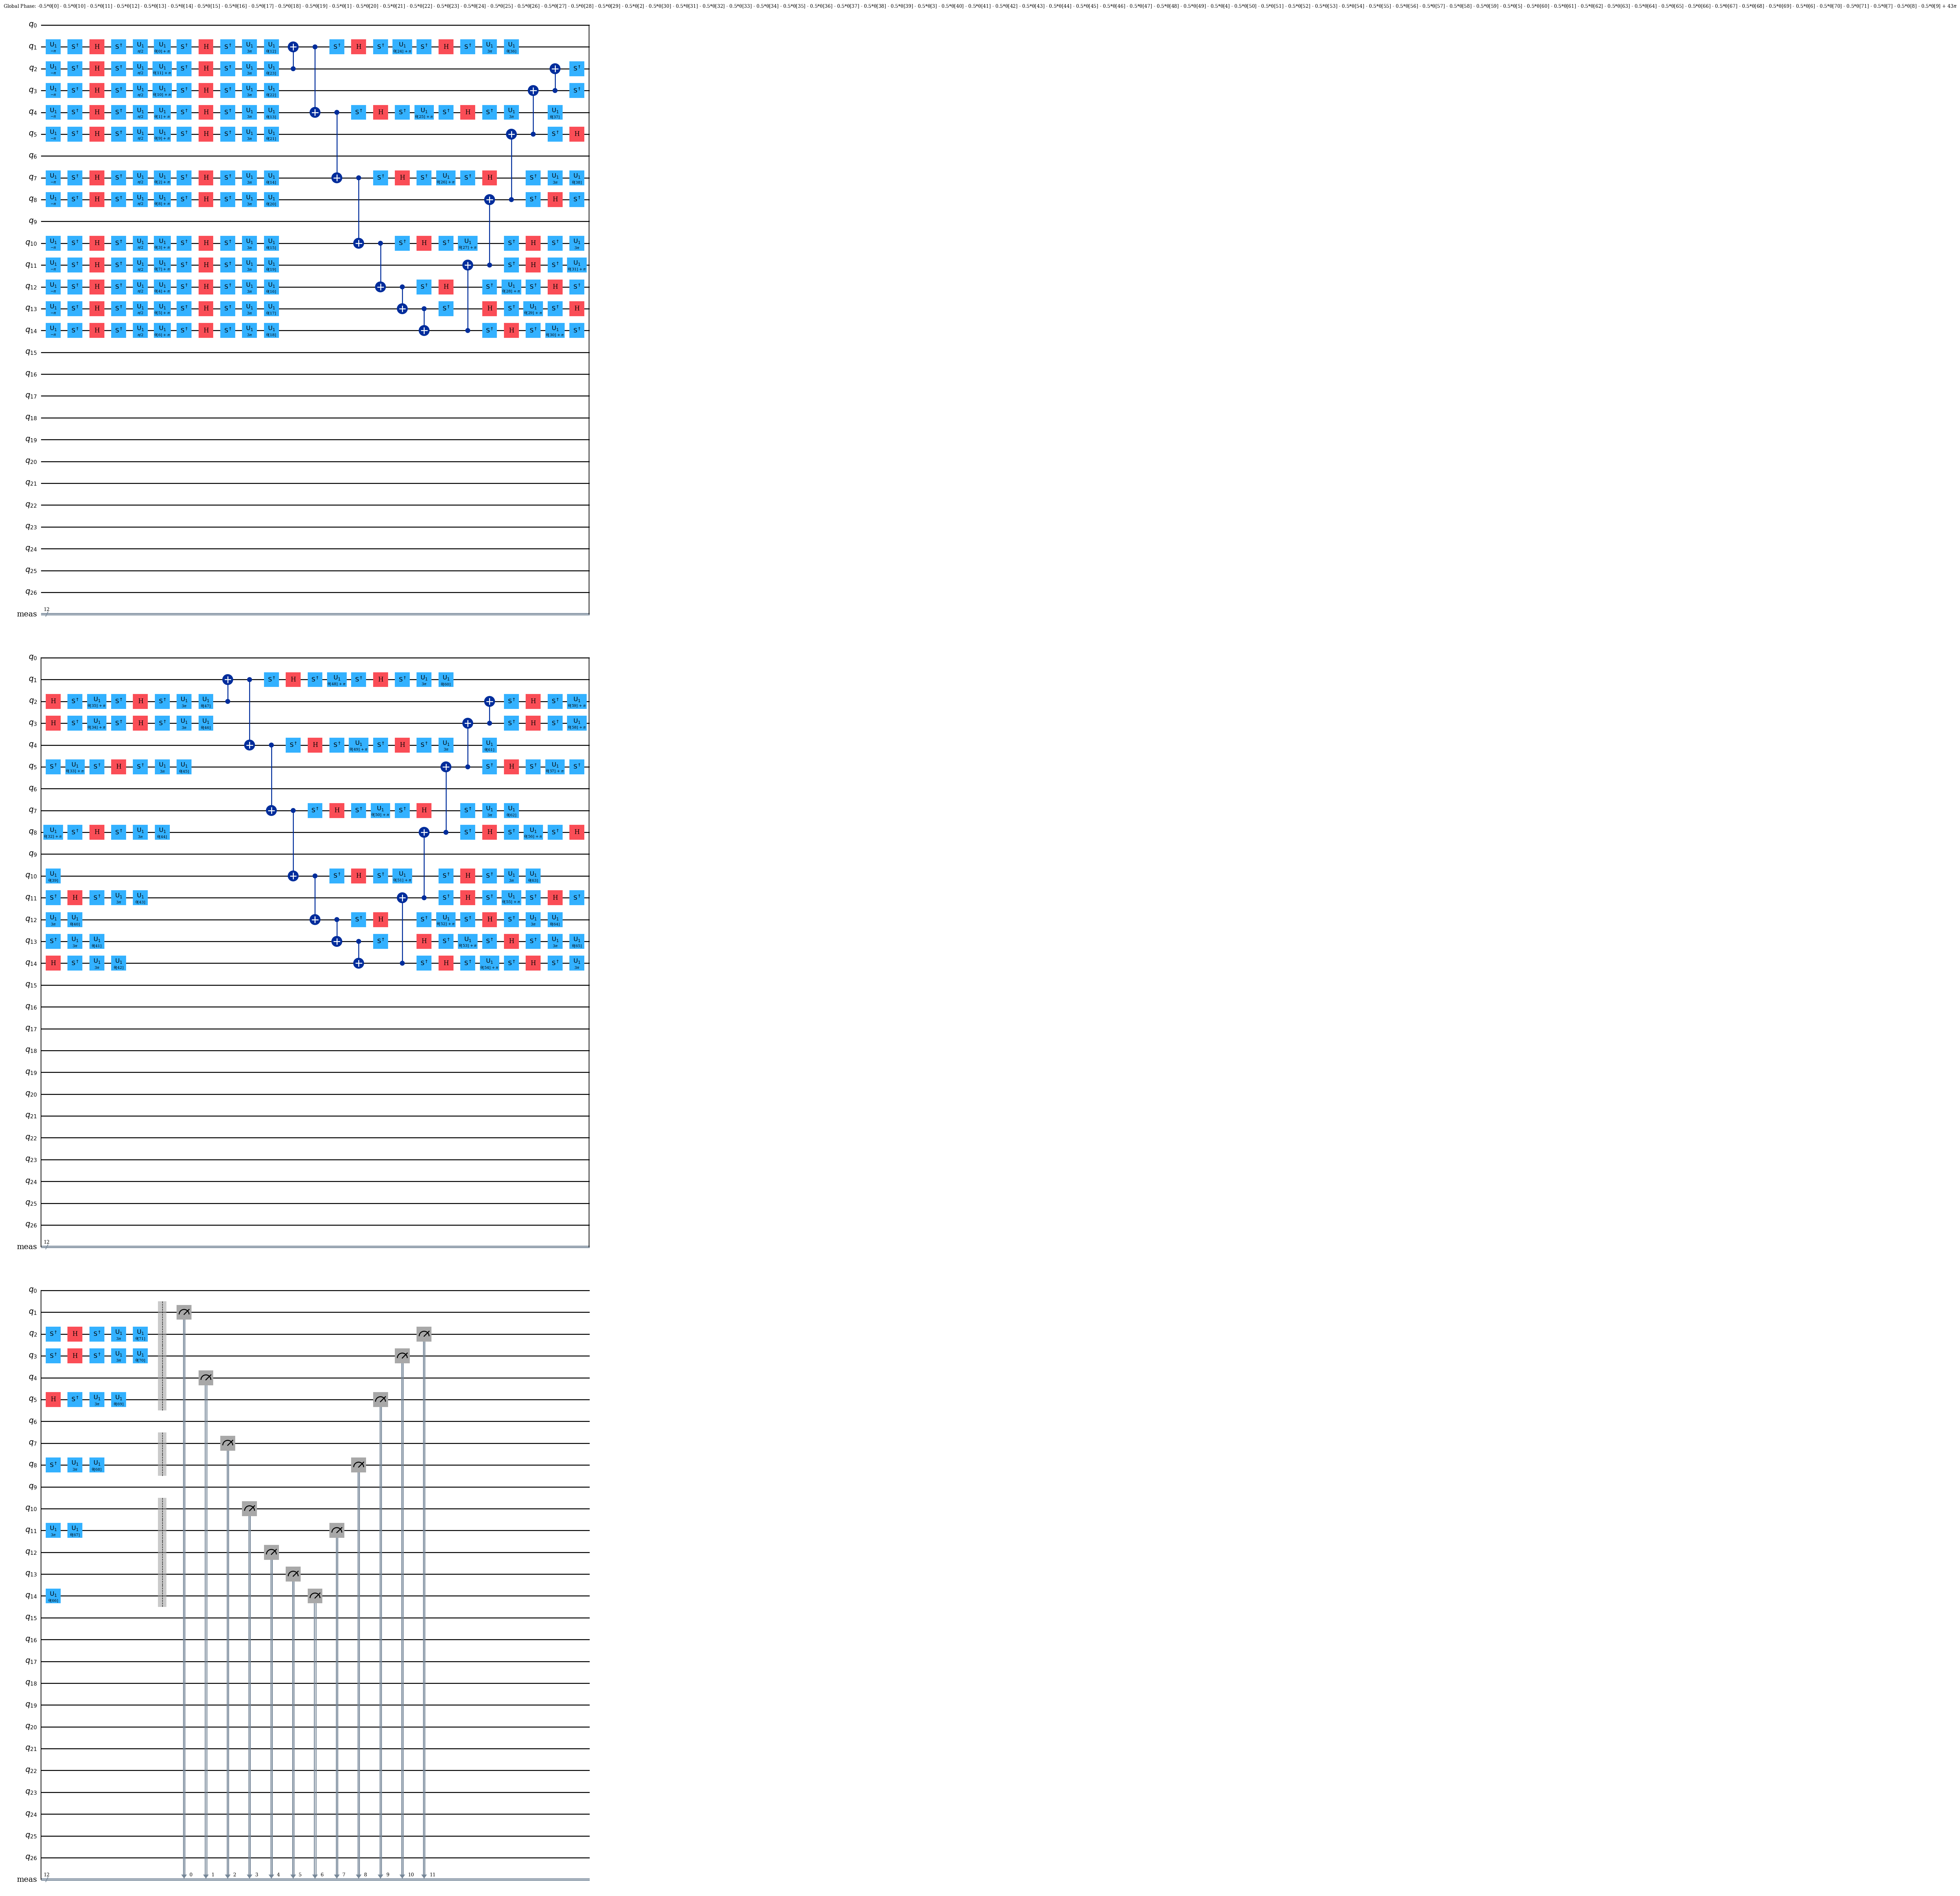

In [41]:
#qc.decompose().draw('mpl', style='iqp')
qc_transpiled.decompose().draw('mpl', style='iqp')

In [17]:
# QCBM class

class qcbm_mmd:
    def __init__(self, circuit, sampler, mmd, p_data, historyc = False, historyg = False, shots = None):
        self.circuit = circuit
        self.sampler = sampler
        self.mmd = mmd
        self.p_data = p_data
        self.historyc = historyc
        self.historyg = historyg
        self.history_cost = []
        self.history_grad = []
        self.history_prob = []
        self.history_par = []
        self.shots = shots

    def cost_tv(self, parameters):
        if self.shots == None:
            prob = dist_pdf(dist(self.sampler, self.circuit, parameters))
        else:
            prob = dist_pdf(self.sampler.run(circuits=self.circuit, parameter_values=parameters, shots = self.shots).result().quasi_dists[0].nearest_probability_distribution())
        cost = np.sum(np.abs(prob-self.p_data)**2)
        if self.historyc:
            self.history_cost.append(cost)
            self.history_par.append(parameters)
            #self.history_prob.append(prob)
        return cost

    def cost(self, parameters):
        if self.shots == None:
            prob = dist_pdf(dist(self.sampler, self.circuit, parameters))
        else:
            prob = dist_pdf(self.sampler.run(circuits=self.circuit, parameter_values=parameters, shots = self.shots).result().quasi_dists[0].nearest_probability_distribution())
        cost = self.mmd.calc(prob, self.p_data)
        if self.historyc:
            self.history_cost.append(cost)
            self.history_par.append(parameters)
            #self.history_prob.append(prob)
        return cost

    def grad_analytic(self, parameters):
        num_of_par = len(parameters)
        circuits_list = [self.circuit] * (2 * num_of_par + 1) 
        parameters_list = []
        gradient = []
        parameters_list.append(parameters)
        for i in range(num_of_par):
            # pi/2 phase
            pars_plus = parameters.copy()
            pars_plus[i] += np.pi/2
            parameters_list.append(pars_plus)
            # -pi/2 phase
            pars_minus = parameters.copy()
            pars_minus[i] -= np.pi/2
            parameters_list.append(pars_minus)
        if self.shots == None:
            jobs = self.sampler.run(circuits=circuits_list, parameter_values=parameters_list)
        else:
            jobs = self.sampler.run(circuits=circuits_list, parameter_values=parameters_list, shots = self.shots)
        results = jobs.result()
        pd_list = []
        for qd in results.quasi_dists:
            pd_list.append(dist_pdf(qd.nearest_probability_distribution()))
        prob = pd_list[0]
        for i in range(1, 2 * num_of_par + 1, 2):
            prob_plus = pd_list[i]
            prob_minus = pd_list[i + 1]
            grad_plus = self.mmd.kernel_expect(prob, prob_plus) - self.mmd.kernel_expect(prob, prob_minus)
            grad_minus = self.mmd.kernel_expect(self.p_data, prob_plus) - self.mmd.kernel_expect(self.p_data, prob_minus)
            gradient.append(grad_plus - grad_minus)
        if self.historyg:
            self.history_prob.append(prob)
            self.history_grad.append(gradient)
            self.history_par.append(parameters)
        return np.array(gradient)

In [18]:
# Prepare data
coords = np.linspace(-4, 4, num_discrete_values)
normal = norm(loc=0.0, scale=0.3)
#prob_data = normal.pdf(coords)
prob_data = 0.4 * norm(loc=-3, scale=0.3).pdf(coords) + 0.3 * norm(loc=1, scale=0.3).pdf(coords) + 0.2 * norm(loc=3, scale=0.6).pdf(coords) + 0.1 * norm(loc=-1, scale=0.6).pdf(coords)
prob_data = prob_data / np.sum(prob_data)

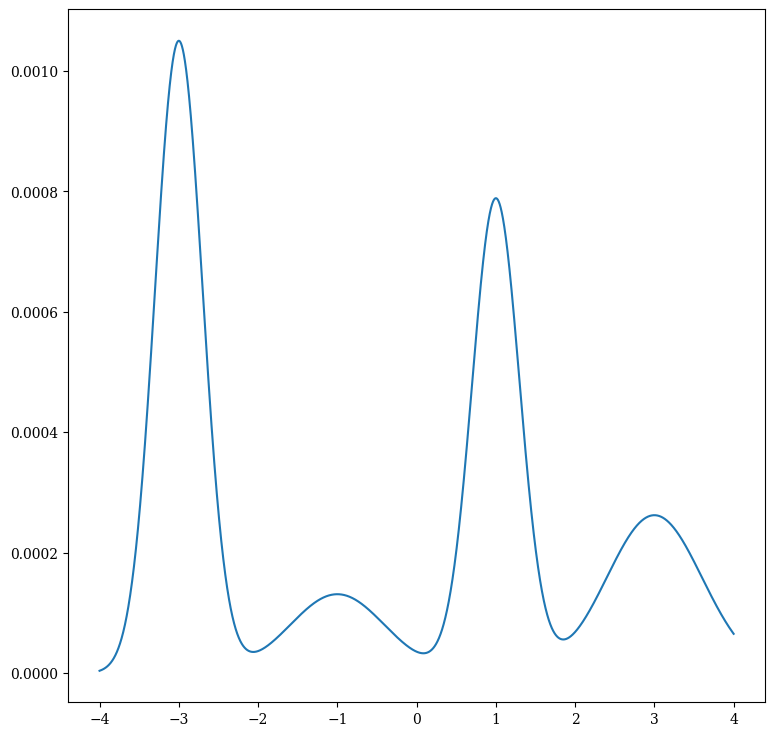

In [19]:
# Visualize data
fig, ax = plt.subplots(figsize=(9, 9))
plot = ax.plot(coords, prob_data)
plt.show()

In [20]:
MMD = mmd(sigma_list=[0.4,8], basis=np.arange(2**num_qubits), kernel=rbf_kernel)

In [21]:
# Set Sampler
# local Aer
#local_sampler = pdf_sampler = AerSampler(backend_options={"seed_simulator": algorithm_globals.random_seed, "method": 'statevector', 'device' : 'GPU'}, run_options={"shots": shots})
# local Base
local_sampler = pdf_sampler = Sampler()
# IBM
#sampler = 'IBM'

In [22]:
# COBYLA training
def train_cobyla(init_params = None, max_iter = 1000, ibm = False, shots = None):
    optimizer = COBYLA(maxiter = max_iter, tol=1e-8, rhobeg=1)
    if init_params == None:
        parameters = np.zeros(qc.num_parameters)
    elif init_params == 'rand':
        parameters = np.random.rand(qc.num_parameters) * np.pi/4
    else:
        parameters = init_params
    if ibm:
        with Session(service, backend=backend) as session:
            ibmsampler = IBMSampler(session=session, options=options)
            qcbm = qcbm_mmd(circuit=qc.copy(), sampler=ibmsampler, mmd=MMD, p_data=prob_data, historyc=True, historyg=False, shots = shots)
            optimizer_result = optimizer.minimize(fun = qcbm.cost_tv, x0 = parameters, bounds = [(-np.pi,np.pi) for a in range(len(parameters))]) 
    else:
        qcbm = qcbm_mmd(circuit=qc.copy(), sampler=local_sampler, mmd=MMD, p_data=prob_data, historyc=True, historyg=False, shots = shots)
        optimizer_result = optimizer.minimize(fun = qcbm.cost_tv, x0 = parameters, bounds = [(-np.pi,np.pi) for a in range(len(parameters))])
    return optimizer_result, qcbm

In [23]:
def bin_mean(data, bin_size):
    if (len(data)%bin_size):
        raise ValueError
    bin_data = []
    for i in range(0, len(data), bin_size):
        bin_data.append(np.mean(data[i:i+bin_size]))
    return bin_data

## Find Optimal Depth

In [39]:
depth_cobyla_x = []
depth_cobyla_fun = []
depth_cobyla_nfev = []
for depth in tqdm(range(1,11)):
    qc = QuantumCircuit(num_qubits)
    qc.h(qc.qubits)
    ansatz = EfficientSU2(num_qubits, entanglement='circular', reps=depth)
    qc.compose(ansatz, inplace=True)
    qc.measure_all()
    res_cobyla, qcbm_cobyla = train_cobyla(max_iter = 1000, ibm=False)
    depth_cobyla_x.append(res_cobyla.x)
    depth_cobyla_fun.append(res_cobyla.fun)
    depth_cobyla_nfev.append(res_cobyla.nfev)
    np.savetxt('RP01E1OD-cobylaD'+str(depth)+'-x.txt', res_cobyla.x)
    np.savetxt('RP01E1OD-cobylaD'+str(depth)+'-fun.txt', [res_cobyla.fun])
    np.savetxt('RP01E1OD-cobylaD'+str(depth)+'-nfev.txt', [res_cobyla.nfev])
np.savetxt('RP01E1OD-cobylaD-nfev.txt', depth_cobyla_nfev)
np.savetxt('RP01E1OD-cobylaD-fun.txt', depth_cobyla_fun)

100%|█████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:47<00:00, 16.78s/it]


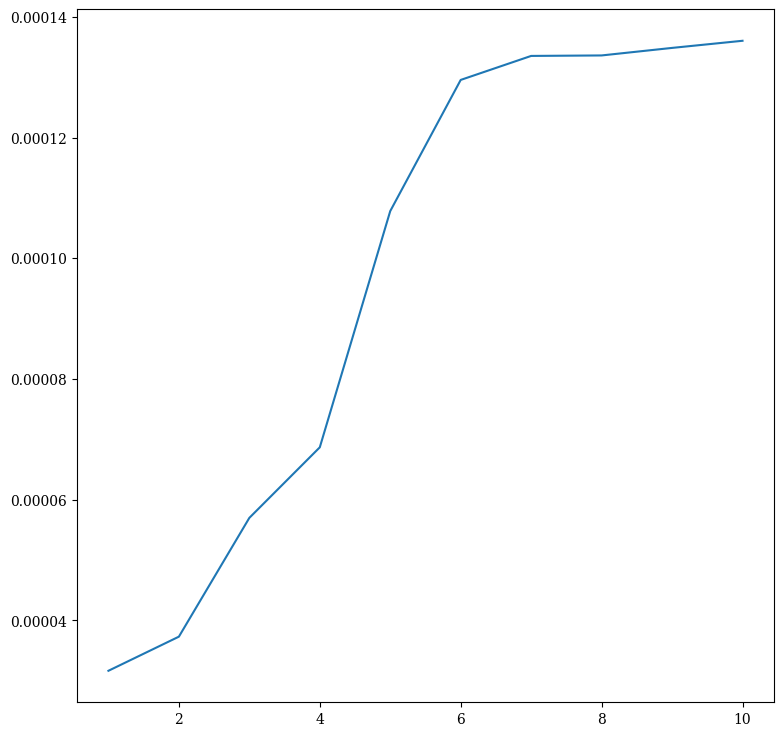

In [44]:
fig, ax = plt.subplots(figsize=(9, 9))
plot = ax.plot(range(1,11), depth_cobyla_fun)
#plot = ax.plot(range(10), depth_cobyla_nfev)
plt.show()

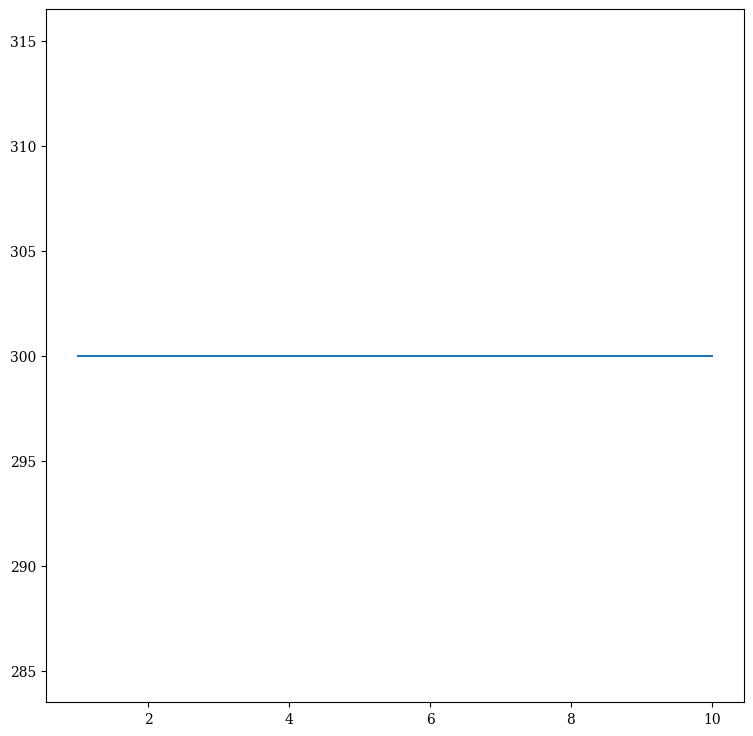

In [42]:
fig, ax = plt.subplots(figsize=(9, 9))
#plot = ax.plot(range(10), depth_cobyla_fun)
plot = ax.plot(range(1,11), depth_cobyla_nfev)
plt.show()

## Train with COBYLA

In [21]:
local_sampler = pdf_sampler = Sampler()

In [27]:
res_cobyla, qcbm_cobyla = train_cobyla(max_iter = 1000, ibm = False, shots = None)

In [28]:
pdf_cobyla = dist_pdf(dist(pdf_sampler, qc.copy(), res_cobyla.x))

In [29]:
bin_pdf_cobyla = bin_mean(pdf_cobyla, 64)

In [30]:
bin_prob_data = bin_mean(prob_data, 64)

In [31]:
bin_coords = bin_mean(coords, 64)

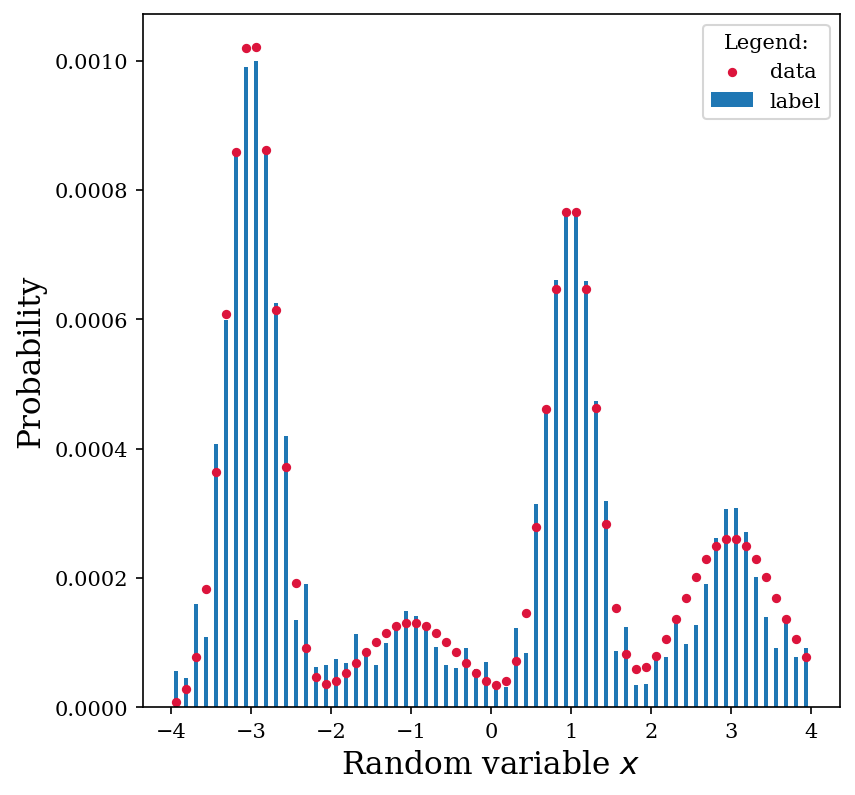

In [32]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=150)
ax.bar(bin_coords, bin_pdf_cobyla, width=0.05, label='label')
ax.scatter(bin_coords, bin_prob_data, color='crimson', s=12, label='data')
ax.set_ylabel(r'Probability', fontsize=15)
ax.set_xlabel(r'Random variable $x$', fontsize=15)
plt.legend(title='Legend:')
#plt.savefig('filename', format='pdf')
plt.show()

In [34]:
print(res_cobyla.x)
print(res_cobyla.nfev)
print(res_cobyla.fun)

[-1.36193918e-03 -4.79532620e-03 -3.70690990e-03 -1.70941551e-03
  2.05730000e-03 -9.27856821e-04 -3.19932003e-03 -2.23266361e-03
 -1.30981469e-01  2.66055031e-01  2.65564997e-02 -1.20826072e-03
 -8.73794450e-02 -6.10356263e-02  4.29870064e-01 -3.70848831e-01
  1.64047574e-01 -5.55606473e-01  1.76215541e-01 -3.75864603e-01
 -3.58139508e-01  1.84202779e-02  5.26476340e-01  2.00868829e-02
 -7.16651181e-05 -9.84607225e-04 -2.86875836e-03 -2.65791016e-03
 -7.40027147e-03  5.23034646e-03  7.80625469e-03  4.22701706e-02
 -2.01436466e-01  8.82939231e-01  9.68910628e-03 -2.03635774e-01
  3.61985075e-02 -3.35797297e-01 -2.40789936e-01 -2.78983017e-01
 -3.92333106e-01  9.01234583e-02  2.98330308e-02 -1.06682946e-01
 -5.58713794e-02  1.88027636e-03  3.84185372e-01  7.36714386e-02
  8.52322183e-03 -3.05563019e-03  1.01476225e-02 -4.02078067e-03
 -7.28142408e-03 -5.40361759e-03 -2.18448830e-04  4.79650455e-03
 -5.18562150e-03  1.75411013e-02 -6.61505880e-01 -3.20125910e-02
 -3.45500454e-01 -1.76428

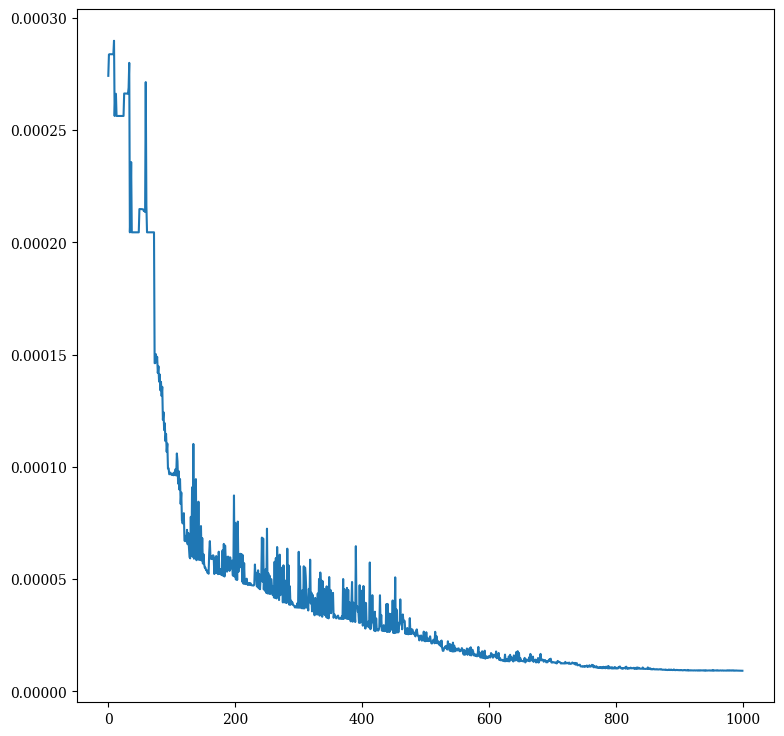

In [33]:
fig, ax = plt.subplots(figsize=(9, 9))
plot = ax.plot(range(res_cobyla.nfev), qcbm_cobyla.history_cost)
plt.show()

## Time tests

In [16]:
tmp_qcbm = qcbm_mmd(circuit=qc.copy(), sampler=local_sampler, mmd=MMD, p_data=prob_data, historyc=False, historyg=False, shots = 2000)

In [48]:
start = time.time()
tmp_qcbm.grad_analytic(np.ones(qc.num_parameters))
end = time.time()

In [49]:
end - start

2.884897232055664

In [17]:
start = time.time()
print(tmp_qcbm.cost_tv (np.zeros(qc.num_parameters)))
end = time.time()

0.0007537831708568269


In [18]:
end - start

0.09855246543884277

In [52]:
start = time.time()
tmp_qcbm.cost (np.ones(qc.num_parameters))
end = time.time()

In [53]:
end - start

0.03675651550292969

## Cobyla noisy

In [31]:
from qiskit_aer.noise import NoiseModel
from qiskit.providers.fake_provider import FakeMumbaiV2
be = FakeMumbaiV2()
noise_model = NoiseModel.from_backend(be)
local_sampler = pdf_sampler = AerSampler(backend_options={"noise_model": noise_model, "seed_simulator": algorithm_globals.random_seed, "method": 'statevector', 'device' : 'CPU'}, run_options={"shots": shots})

In [33]:
res_cobylan, qcbm_cobylan = train_cobyla(max_iter = 1000, ibm = False, shots = 10000)

In [ ]:
np.savetxt

In [24]:
pdf_cobylan = dist_pdf(dist(pdf_sampler, qc.copy(), res_cobylan.x))

In [56]:
bin_pdf_cobylan = bin_mean(pdf_cobylan, 64)

NameError: name 'pdf_cobylan' is not defined

In [57]:
bin_prob_data = bin_mean(prob_data, 64)

In [58]:
bin_coords = bin_mean(coords, 64)

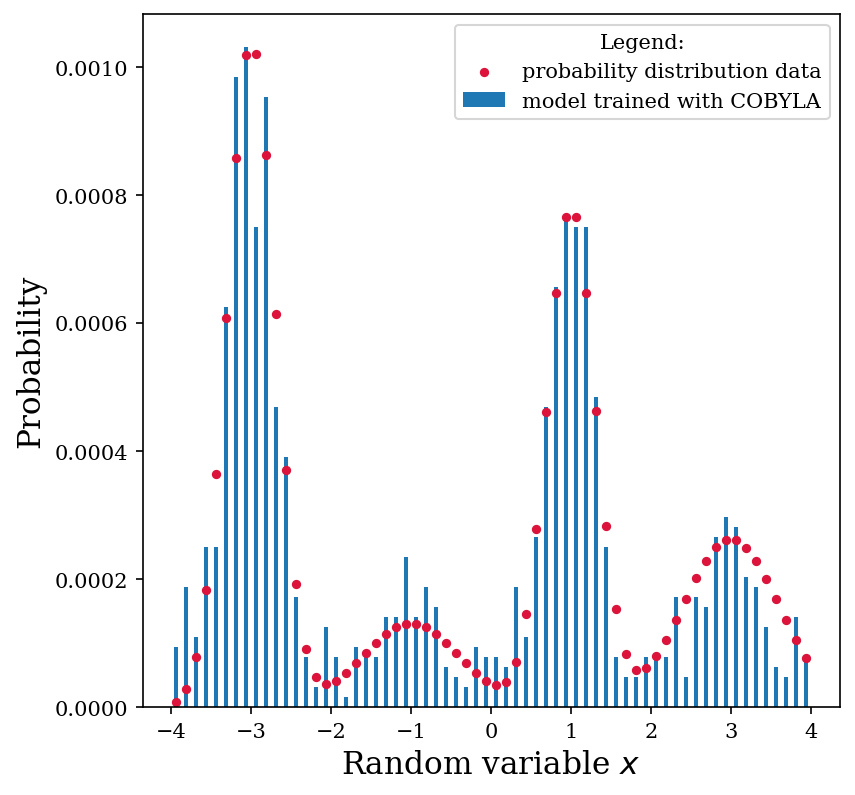

In [59]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=150)
ax.bar(bin_coords, bin_pdf_cobylan, width=0.05, label='model trained with COBYLA')
ax.scatter(bin_coords, bin_prob_data, color='crimson', s=12, label='probability distribution data')
ax.set_ylabel(r'Probability', fontsize=15)
ax.set_xlabel(r'Random variable $x$', fontsize=15)
plt.legend(title='Legend:')
plt.savefig('RP01-QCBM-E1-model_and_data10000.pdf', format='pdf', dpi=150, bbox_inches='tight')
plt.show()

In [35]:
print(res_cobylan.x)
print(res_cobylan.nfev)
print(res_cobylan.fun)

[ 1.23755452e-01 -3.76964856e-02  5.60494397e-02 -4.17135359e-02
 -3.14007136e-02 -2.18024476e-02 -2.73018927e-02 -1.10067429e-02
 -1.43420037e-01  2.26471514e-01 -2.07490220e-01  3.74818647e-02
  4.84856410e-01 -1.34878651e-01 -1.23759748e-01 -4.75583203e-01
  1.10965291e+00  1.00604288e+00  2.59942545e-01 -4.08609331e-01
 -6.14492567e-02 -1.19473367e-01  4.98984271e-01 -1.63716513e-01
  1.64557278e-02 -4.52633888e-02  7.01532711e-02  3.09437408e-04
 -9.30559615e-03 -4.93596716e-02  5.41725211e-03  2.19073245e-02
 -3.86618562e-01  1.52539588e+00  4.96920618e-02 -2.04716024e-01
 -1.20967770e-01 -2.39686754e-01 -1.39075116e-02  4.13115354e-01
  2.26808406e-01 -9.27101161e-02 -5.12427289e-02 -2.03298795e-01
 -2.25944883e-01  3.62082422e-01  2.21824843e-02  4.79240660e-02
  1.20746565e-01  2.38115368e-02  2.08544575e-02  6.21022290e-02
  2.84442471e-02 -2.62016168e-03  1.20641739e-03  4.16559038e-02
 -5.69005445e-01  3.37133312e-01 -8.69421957e-01 -5.52139591e-02
  1.25016140e-01  1.13588

In [38]:
if True:
    np.savetxt('RP01E1OD-cobyla-x.txt', res_cobylan.x)
    np.savetxt('RP01E1OD-cobyla-fun.txt', [res_cobylan.fun])
    np.savetxt('RP01E1OD-cobyla-nfev.txt', [res_cobylan.nfev])
    np.savetxt('RP01E1OD-cobyla-cost_hist.txt', qcbm_cobylan.history_cost)
    np.savetxt('RP01E1OD-cobyla-par_hist.txt', qcbm_cobylan.history_par)

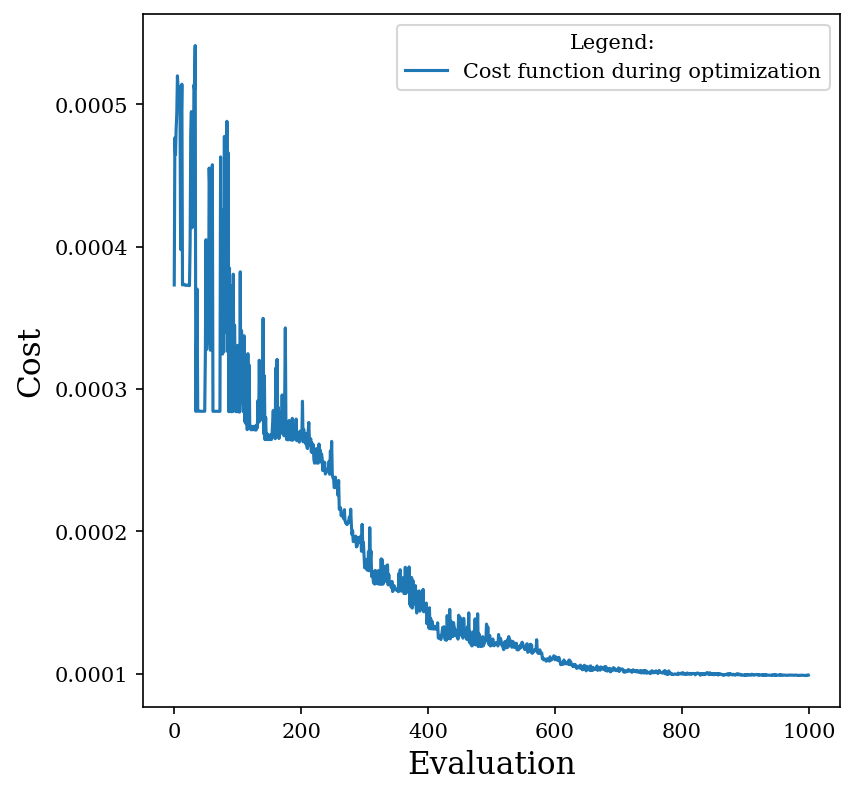

In [61]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=150)
plot = ax.plot(range(res_cobylan.nfev), qcbm_cobylan.history_cost, label = 'Cost function during optimization')
ax.set_ylabel(r'Cost', fontsize=15)
ax.set_xlabel(r'Evaluation', fontsize=15)
plt.legend(title='Legend:')
plt.savefig('RP01-QCBM-E1-cost_evaluation100000.pdf', format='pdf', dpi=150, bbox_inches='tight')
plt.show()

In [43]:
from qiskit_ibm_runtime.options import TranspilationOptions

In [44]:
options = Options(optimization_level=3, transpilation=TranspilationOptions(initial_layout=[1,4,7,10,12,13,14,11,8,5,3,2]))

In [24]:
ph = np.loadtxt('RP01E1OD-cobyla-par_hist.txt')

In [25]:
len(ph)

1000

In [27]:
cpar = ph[-1]

In [51]:
with Session(service, backend=backend) as session:
    ibmsampler = IBMSampler(session=session)
    Qjobs = ibmsampler.run(circuits=qc.copy(), parameter_values=cpar, shots = 4000)
    Qresults = Qjobs.result()
    session.cancel()

In [32]:
Qparameters_list = ph.copy()
Qcircuits_list = [qc_transpiled] * len(Qparameters_list)
Qshots = 8000
Qcost_history = []
with Session(service, backend=backend) as session:
    ibmsampler = IBMSampler(session=session, options=options)
    Qjobs = ibmsampler.run(circuits=Qcircuits_list, parameter_values=Qparameters_list, shots = Qshots, skip_transpilation=True,)
    Qresults = Qjobs.result()
    session.cancel()

RuntimeJobFailureError: 'Unable to retrieve job result. RequestException: Error making POST request to /results/job/final: 413 Client Error: Request Entity Too Large for url: http://127.0.0.1:8080/results/job/final '

In [52]:
Qpd_list = []
for qd in Qresults.quasi_dists:
    Qpd_list.append(dist_pdf(qd.nearest_probability_distribution()))
np.savetxt('RP01-QCBM-Qpd_list.txt', Qpd_list)

In [53]:
Qcost_list = []
for pd in Qpd_list:
    Qcost_list.append(np.sum(np.abs(prob_data-pd)**2))

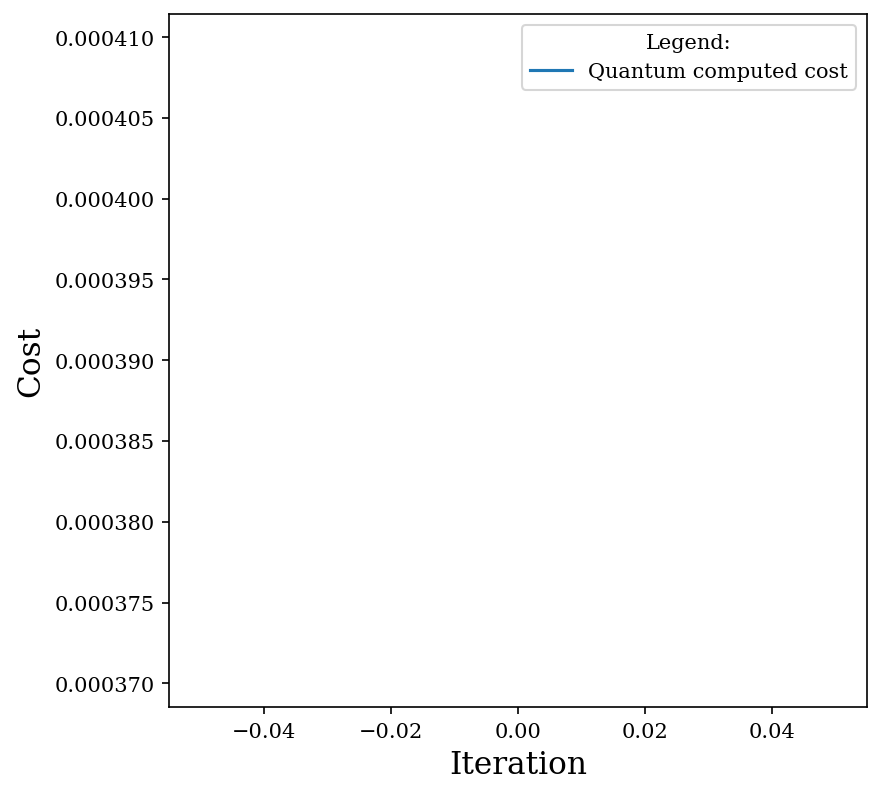

In [54]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=150)
plot = ax.plot(range(len(Qcost_list)), Qcost_list, label = 'Quantum computed cost')
ax.set_ylabel(r'Cost', fontsize=15)
ax.set_xlabel(r'Iteration', fontsize=15)
plt.legend(title='Legend:')
plt.savefig('RP01-QCBM-E1-Qcost_iterations.pdf', format='pdf')

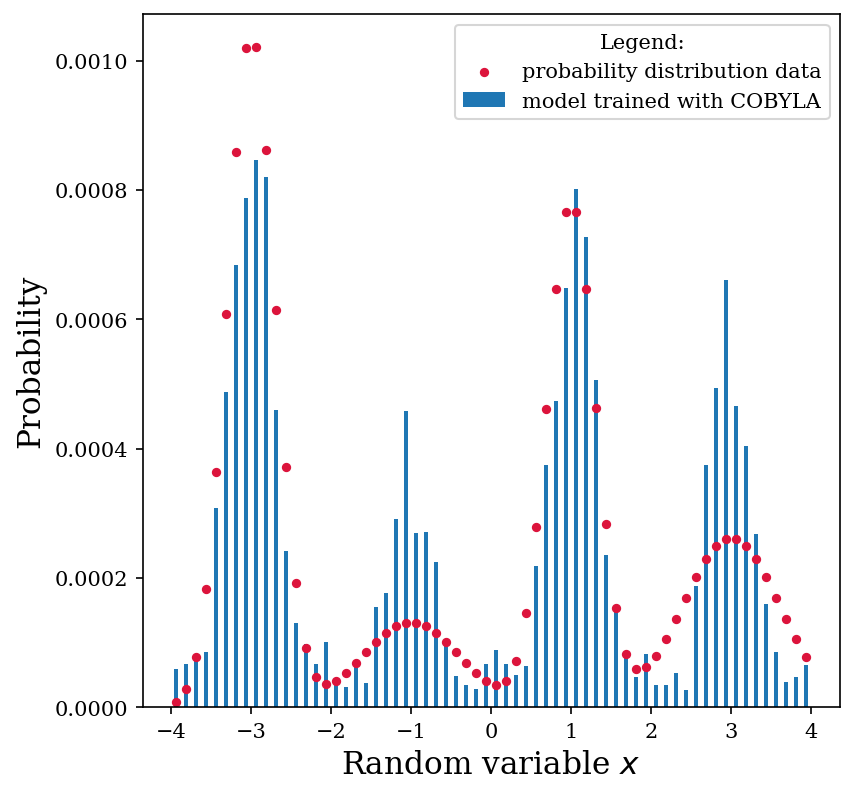

In [63]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=150)
ax.bar(bin_coords, bin_mean(Qpd_list[0], 64), width=0.05, label='model trained with COBYLA')
ax.scatter(bin_coords, bin_prob_data, color='crimson', s=12, label='probability distribution data')
ax.set_ylabel(r'Probability', fontsize=15)
ax.set_xlabel(r'Random variable $x$', fontsize=15)
plt.legend(title='Legend:')
plt.savefig('RP01-QCBM-E1-model_and_data10000Q.pdf', format='pdf', dpi=150, bbox_inches='tight')
plt.show()